https://arxiv.org/pdf/1411.3286.pdf

https://cosmohub.pic.es/

If you make use of the MICE mocks for scientific publications, we kindly ask you to cite the following papers:

"The MICE grand challenge lightcone simulation - I. Dark matter clustering". Fosalba, P.; Crocce, M.; Gaztañaga, E.; Castander, F. J., MNRAS, 448, 2987 (2015)

"The MICE Grand Challenge Lightcone Simulation II: Halo and Galaxy catalogues". Crocce, M.; Castander, F. J.; Gaztanaga, E.; Fosalba, P.; Carretero, J., MNRAS, 453, 1513 (2015)

"The MICE Grand Challenge light-cone simulation - III. Galaxy lensing mocks from all-sky lensing maps". Fosalba, P.; Gaztañaga, E.; Castander, F. J.; Crocce, M., MNRAS, 447, 1319 (2015)

"An algorithm to build mock galaxy catalogues using MICE simulations". Carretero, J.; Castander, F. J.; Gaztañaga, E.; Crocce, M.; Fosalba, P., MNRAS, 447, 646 (2015)

"Measuring the growth of matter fluctuations with third-order galaxy correlations", Hoffmann K., Bel J., Gaztanaga E., Crocce M., Fosalba P., Castander F.J., MNRAS, 447, 1724 (2015)



# Euclid Filter

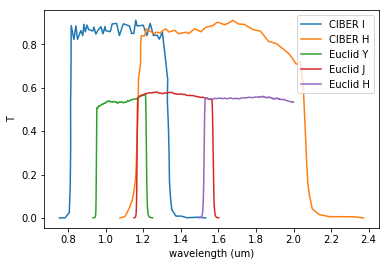

In [7]:
filtdir = '/Users/ytcheng/ciber/lephare/lephare_dev/filt/'

for band in ['I','H']:
    d = np.loadtxt(filtdir + 'ciber/' + band + '.pb',skiprows=1)
    plt.plot(d[:,0]/1e4,d[:,1],label='CIBER '+band)
for band in ['Y','J','H']:
    d = np.loadtxt(filtdir + 'euclid/Euclid_NISP.' + band + '.pb',skiprows=0)
    plt.plot(d[:,0]/1e4,d[:,1],label='Euclid '+band)
plt.xlabel('wavelength (um)')
plt.ylabel('T')
plt.legend()

# MICECAT statistics

MICECAT field 0, 0 < ra < 2, 0 < dec < 2
Ngal=189, Ncent = 151 (79.89 %), Nsat=38 (20.11 %)
Ngal=845, Ncent = 565 (66.86 %), Nsat=280 (33.14 %)
Ngal=3085, Ncent = 1994 (64.64 %), Nsat=1091 (35.36 %)
Ngal=8846, Ncent = 5598 (63.28 %), Nsat=3248 (36.72 %)


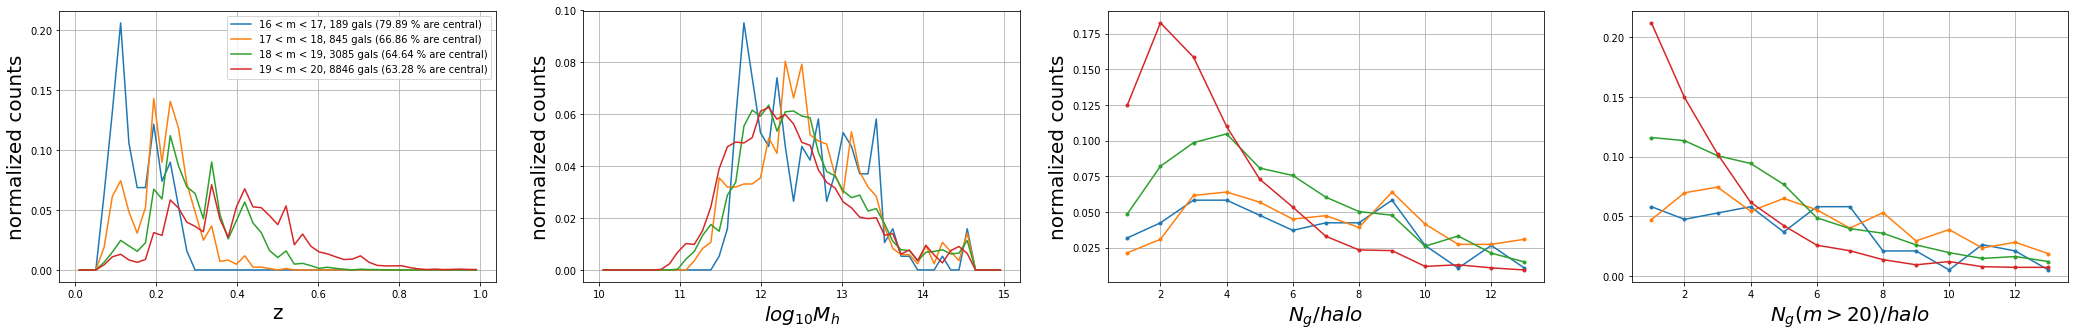

In [18]:
from micecat import *

icat = 0
df = get_micecat_df(icat)

fig, ax = plt.subplots(1, 4, figsize = (36,5))

zbinedges = np.linspace(0,1,50)
zbins = (zbinedges[1:] + zbinedges[:-1])/2
Mhbinedges = np.linspace(10,15,50)
Mhbins = (Mhbinedges[1:] + Mhbinedges[:-1])/2
Ngbinedges = np.arange(1,15,1) - 0.5
Ngbins = (Ngbinedges[1:] + Ngbinedges[:-1])/2
for i,(m_min, m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    dfi = df[(df['I']>=m_min) & (df['I']<m_max)]
    Ng = len(dfi)
    Ncen = len(dfi[dfi['flag_central']==0]) 
    Nsat = len(dfi[dfi['flag_central']==1]) 
    
    histz,_ = np.histogram(dfi['z_cgal'], bins=zbinedges)
    histMh,_ = np.histogram(dfi['lmhalo'], bins=Mhbinedges)
    
    Nunmasked, Ninhalo = [], []
    for haloid in dfi['unique_halo_id']:
        dfj = df[df['unique_halo_id']==haloid]
        Nunmasked.append(len(dfj[(dfj['I']>20)]))
        Ninhalo.append(len(dfj))
    Nunmasked = np.array(Nunmasked)
    Ninhalo = np.array(Ninhalo)
    
    histNinhalo,_ = np.histogram(Ninhalo,bins=Ngbinedges)
    histunmasked,_ = np.histogram(Nunmasked,bins=Ngbinedges)

    ax[0].plot(zbins,histz/Ng, label='%d < m < %d, %d gals (%.2f %% are central)'\
               %(m_min, m_max, Ng, Ncen/Ng*100))
    ax[1].plot(Mhbins,histMh/Ng)
    ax[2].plot(Ngbins,histNinhalo/Ng,'.-')
    ax[3].plot(Ngbins,histunmasked/Ng,'.-')
    print('Ngal=%d, Ncent = %d (%.2f %%), Nsat=%d (%.2f %%)'\
          %(Ng,Ncen,Ncen/Ng*100,Nsat,Nsat/Ng*100))

ax[0].legend()
ax[0].set_xlabel('z', fontsize=20)
ax[0].set_ylabel('normalized counts', fontsize=20)
ax[1].set_xlabel(r'$log_{10}M_h$', fontsize=20)
ax[1].set_ylabel('normalized counts', fontsize=20)
ax[2].set_ylabel('normalized counts', fontsize=20)
ax[2].set_xlabel(r'$N_g/halo$', fontsize=20)
ax[2].set_ylabel('normalized counts', fontsize=20)
ax[3].set_xlabel(r'$N_g(m>20)/halo$', fontsize=20)
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
# fig.savefig('/Users/ytcheng/Desktop/micecat.png',
#              dpi = 100, bbox_inches='tight')

In [8]:
from micecat import *

icat = 0
df = get_micecat_df(icat)
df = df.sort_values(by=['unique_halo_id'])
df['fluxI'] = ABmag2Fjy(df['I'].values)
df['fluxH'] = ABmag2Fjy(df['H'].values)

dfc = df[df['flag_central']==0]

fluxItot = []
fluxHtot = []
davg, dmax = [], []

for i, haloid in enumerate(dfc['unique_halo_id']):
    
    dfi = df[df['unique_halo_id']==haloid]
    if np.all(dfi['flag_central']==1):
        continue
        
    fluxItot.append(np.sum(dfi['fluxI']))
    fluxHtot.append(np.sum(dfi['fluxH']))
    
    xc,yc = dfc.iloc[i]['x'], dfc.iloc[i]['y']
    dx, dy = dfi['x'].values - xc, dfi['y'].values - yc
    d = np.sort(np.sqrt((dx**2 + dy**2)))[1:]
    if len(d) == 0:
        davg.append(0)
        dmax.append(0)
    else:
        davg.append(np.mean(d))
        dmax.append(np.max(d))
    if i%1000 == 0:
        print(i, len(np.unique(df['unique_halo_id'])))

fluxItot = np.array(fluxItot)
fluxHtot = np.array(fluxHtot)
davg = np.array(davg)*7
dmax = np.array(dmax)*7

dfc['fluxItot'] = fluxItot
dfc['fluxHtot'] = fluxHtot
dfc['davg'] = davg
dfc['dmax'] = dmax

clear_output()

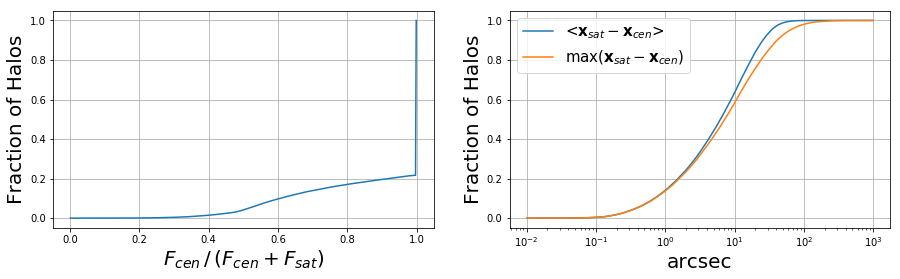

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
fbinedges = np.linspace(0,1,500)
fbins = (fbinedges[1:] + fbinedges[:-1]) / 2
histf,_ = np.histogram(dfc['fluxI']/dfc['fluxItot'], bins=fbinedges)
histf =  histf / len(dfc)
ax[0].plot(fbins,np.cumsum(histf))
ax[0].set_xlabel('$F_{cen}\,/\,(F_{cen}+F_{sat})$', fontsize=20)
ax[0].set_ylabel('Fraction of Halos', fontsize=20)
ax[0].grid()

davg, dmax = dfc['davg'].values, dfc['dmax'].values
davg, dmax = davg[davg>0], dmax[dmax>0]

dbinedges = np.logspace(-2,3,500)
dbins = np.sqrt(dbinedges[1:] * dbinedges[:-1])

histdavg,_ = np.histogram(davg, bins=dbinedges)
histdavg =  histdavg / len(davg)
ax[1].semilogx(dbins,np.cumsum(histdavg), label=r'<$\mathbf{x}_{sat}-\mathbf{x}_{cen}$>')

histdmax,_ = np.histogram(dmax, bins=dbinedges)
histdmax =  histdmax / len(dmax)
ax[1].semilogx(dbins,np.cumsum(histdmax), label=r'max($\mathbf{x}_{sat}-\mathbf{x}_{cen}$)')

ax[1].set_xlabel('arcsec', fontsize=20)
ax[1].set_ylabel('Fraction of Halos', fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=15)

# Stack 1-Halo

In [1]:
from micecat import *

In [ ]:
# inst = 1
# for icat in range(90):
#     data_dict = run_micecat_1h(inst, icat)
# for ibatch in range(9):
#     run_micecat_batch(inst, ibatch, run_type='1h')

Text(0, 0.5, 'I [$mW/m^2/sr$]')

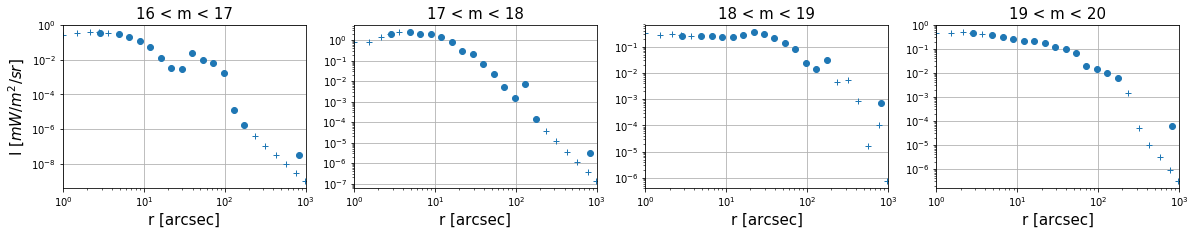

In [14]:
inst = 1
fig, ax = plt.subplots(1,4,figsize=(20,3))
data_all = []
for icat in [0]:#range(90):
    savedir='./micecat_data/'
    fname  = 'onehalo_TM%d_icat%d.pkl'%(inst, icat)
    if fname not in os.listdir(savedir):
        continue
        
    with open(savedir + fname,"rb") as f:
        data_dict = pickle.load(f)
        
    rbins = data_dict['rbins']
    data = data_dict['data']
    data_all.append(data)
    for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
        ax[im].loglog(rbins,data[im],alpha=0.1,c='C0')

data_all = np.array(data_all)
for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
    data_avg = np.mean(data_all, axis=0)[im]
    data_std = np.std(data_all, axis=0)[im]
    plot_err_log(rbins, data_avg, data_std,
             ax=ax[im], color='k',label='Average Excess')
    ax[im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
    ax[im].set_xlabel('r [arcsec]', fontsize=15)
    ax[im].set_ylim([1e-2,3e2])
    ax[im].set_xlim([1e0,1e3])
    ax[im].grid()
ax[0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)

# Run map filtering test

In [1]:
from micecat import *

In [3]:
# inst = 1
# for icat in range(90):
#     data, rbins, filt_order_arr = run_micecat_fliter_test(inst, icat)
# for ibatch in range(9):
#     run_micecat_batch(inst, ibatch)

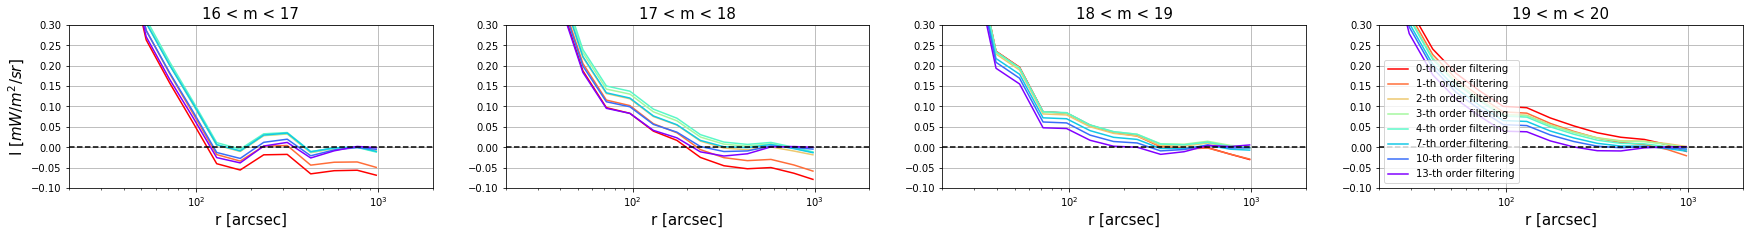

In [126]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(1, 0, len(filt_order_arr)))

inst = 1
savedir = './micecat_data/'
for icat in np.arange(0,90,20):
    fname  = savedir + 'filter_test_TM%d_icat%d.pkl'%(inst, icat)

    with open(fname,"rb") as f:
        data_dict = pickle.load(f)
    
    filt_order_arr = data_dict['filt_order_arr']
    rbins = data_dict['rbins']
    data = data_dict['data']
    
    plt.close()
    fig, ax = plt.subplots(1,4,figsize=(30,3))
    for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
        for ifilt, (filt_order, c) in enumerate(zip(filt_order_arr, colors)):
            ax[im].semilogx(rbins, data[ifilt, im],c=c,label='%d-th order filtering'%filt_order)
        ax[im].axhline(0, c='k', ls='--')
        ax[im].set_ylim([-0.1,0.3])
        ax[im].set_xlim([2e1,2e3])
        ax[im].grid()
        ax[im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[im].set_xlabel('r [arcsec]', fontsize=15)
    ax[0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
    ax[-1].legend()
    fig.savefig('/Users/ytcheng/Desktop/micecat_filter_icat%d.png'%icat,
                 dpi = 150, bbox_inches='tight')
    

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide


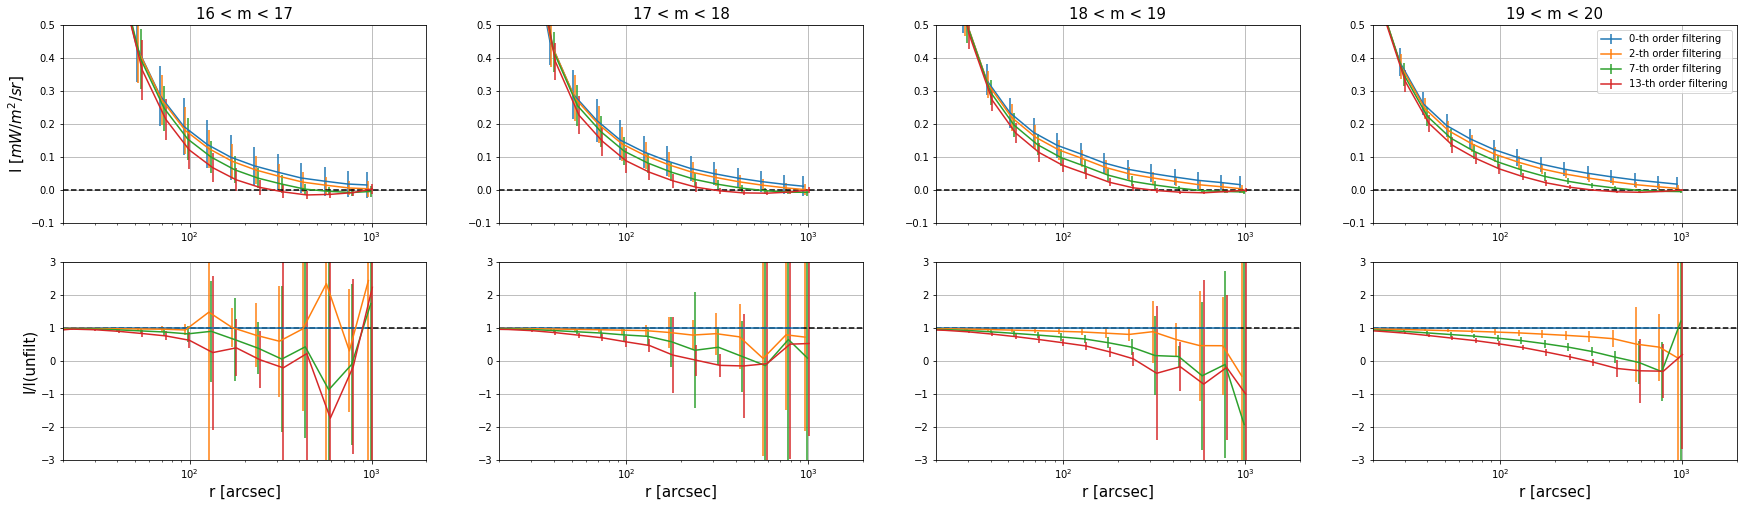

In [22]:
inst = 1
savedir = './micecat_data/'

data_all = []
for icat in range(90):
    fname  = savedir + 'filter_test_TM%d_icat%d.pkl'%(inst, icat)

    with open(fname,"rb") as f:
        data_dict = pickle.load(f)
    
    filt_order_arr = np.array(data_dict['filt_order_arr'])
    rbins = np.array(data_dict['rbins'])
    data = data_dict['data']
    
    data_all.append(data)
data_all = np.array(data_all)

fig, ax = plt.subplots(2,4,figsize=(30,8))
for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
    for ifilt, filt_order in enumerate(filt_order_arr):
        if filt_order not in [0,2,7,13]:
            continue
        xoff = (ifilt - len(filt_order_arr)/2)*0.01 + 1
        data = data_all[:,ifilt,im,:]
        prof_avg = np.mean(data, axis = 0)
        prof_err = np.std(data ,axis = 0)
        ax[0][im].errorbar(rbins*xoff, prof_avg, prof_err,
                        label='%d-th order filtering'%filt_order)
        
        data = data = data_all[:,ifilt,im,:] / data_all[:,0,im,:]
        prof_avg = np.mean(data, axis = 0)
        prof_err = np.std(data ,axis = 0)
        ax[1][im].errorbar(rbins*xoff, prof_avg, prof_err,
                        label='%d-th order filtering'%filt_order)
        
    ax[0][im].set_xscale('log')
    ax[0][im].axhline(0, c='k', ls='--')
    ax[0][im].set_ylim([-0.1,0.5])
    ax[0][im].set_xlim([2e1,2e3])
    ax[0][im].grid()
    ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
    ax[1][im].set_xscale('log')
    ax[1][im].axhline(1, c='k', ls='--')
    ax[1][im].set_ylim([-3,3])
    ax[1][im].set_xlim([2e1,2e3])
    ax[1][im].grid()
    ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[1][0].set_ylabel('I/I(unfilt)', fontsize=15)
ax[0][-1].legend()
fig.savefig('/Users/ytcheng/Desktop/micecat_filter.png',
             dpi = 150, bbox_inches='tight')

# Stack only central gals

In [1]:
from micecat import *

In [3]:
# inst = 1
# for icat in range(90):
#     data, rbins, filt_order_arr = run_micecat_fliter_test_cen(inst, icat)

# inst = 1
# for ibatch in range(9):
#     run_micecat_batch(inst, ibatch, run_type='cen')

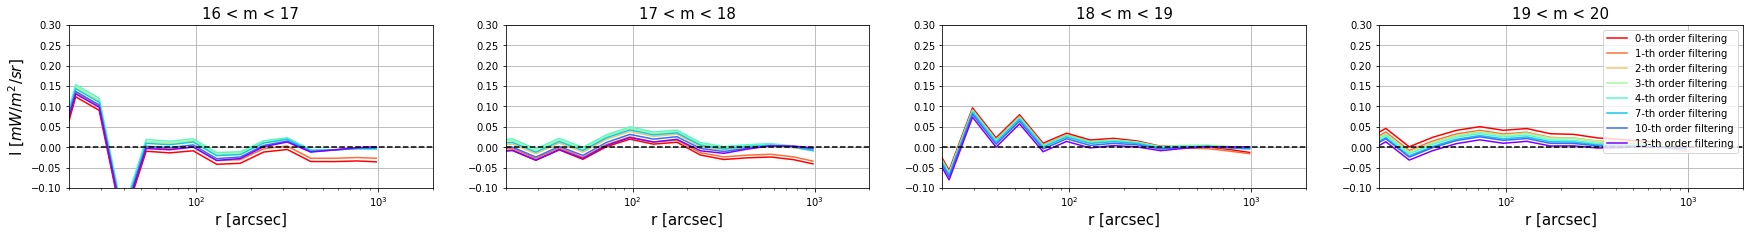

In [15]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(1, 0, len(filt_order_arr)))

inst = 1
savedir = './micecat_data/'
for icat in np.arange(0,90,20):
    fname  = savedir + 'filter_test_cen_TM%d_icat%d.pkl'%(inst, icat)

    with open(fname,"rb") as f:
        data_dict = pickle.load(f)
    
    filt_order_arr = data_dict['filt_order_arr']
    rbins = data_dict['rbins']
    data = data_dict['data']
    
    plt.close()
    fig, ax = plt.subplots(1,4,figsize=(30,3))
    for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
        for ifilt, (filt_order, c) in enumerate(zip(filt_order_arr, colors)):
            ax[im].semilogx(rbins, data[ifilt, im],c=c,label='%d-th order filtering'%filt_order)
        ax[im].axhline(0, c='k', ls='--')
        ax[im].set_ylim([-0.1,0.3])
        ax[im].set_xlim([2e1,2e3])
        ax[im].grid()
        ax[im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[im].set_xlabel('r [arcsec]', fontsize=15)
    ax[0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
    ax[-1].legend()
    fig.savefig('/Users/ytcheng/Desktop/micecat_filter_cen_icat%d.png'%icat,
                 dpi = 150, bbox_inches='tight')

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide


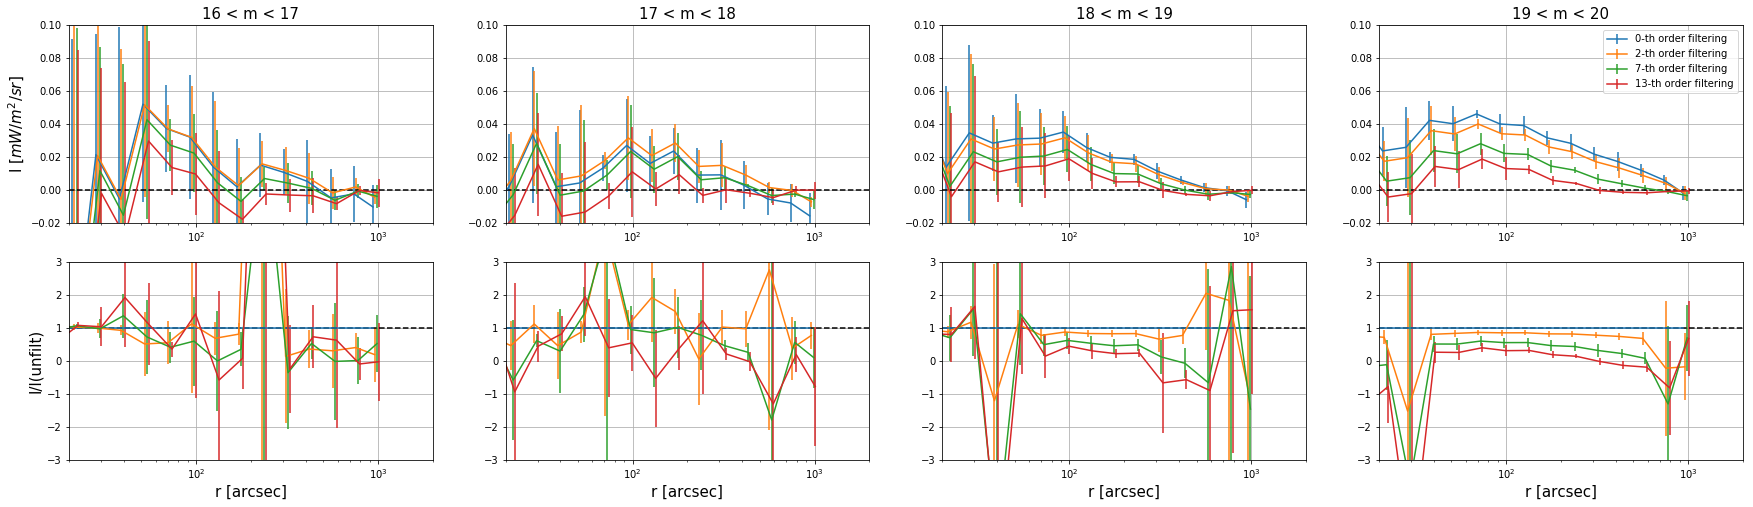

In [21]:
inst = 1
savedir = './micecat_data/'

data_all = []
for icat in np.arange(0,90,20):#range(90):
    fname  = savedir + 'filter_test_cen_TM%d_icat%d.pkl'%(inst, icat)

    with open(fname,"rb") as f:
        data_dict = pickle.load(f)
    
    filt_order_arr = np.array(data_dict['filt_order_arr'])
    rbins = np.array(data_dict['rbins'])
    data = data_dict['data']
    
    data_all.append(data)
data_all = np.array(data_all)

fig, ax = plt.subplots(2,4,figsize=(30,8))
for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
    for ifilt, filt_order in enumerate(filt_order_arr):
        if filt_order not in [0,2,7,13]:
            continue
        xoff = (ifilt - len(filt_order_arr)/2)*0.01 + 1
        data = data_all[:,ifilt,im,:]
        prof_avg = np.mean(data, axis = 0)
        prof_err = np.std(data ,axis = 0)
        ax[0][im].errorbar(rbins*xoff, prof_avg, prof_err,
                        label='%d-th order filtering'%filt_order)
        
        data = data = data_all[:,ifilt,im,:] / data_all[:,0,im,:]
        prof_avg = np.mean(data, axis = 0)
        prof_err = np.std(data ,axis = 0)
        ax[1][im].errorbar(rbins*xoff, prof_avg, prof_err,
                        label='%d-th order filtering'%filt_order)
        
    ax[0][im].set_xscale('log')
    ax[0][im].axhline(0, c='k', ls='--')
    ax[0][im].set_ylim([-0.02,0.1])
    ax[0][im].set_xlim([2e1,2e3])
    ax[0][im].grid()
    ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
    ax[1][im].set_xscale('log')
    ax[1][im].axhline(1, c='k', ls='--')
    ax[1][im].set_ylim([-3,3])
    ax[1][im].set_xlim([2e1,2e3])
    ax[1][im].grid()
    ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[1][0].set_ylabel('I/I(unfilt)', fontsize=15)
ax[0][-1].legend()
fig.savefig('/Users/ytcheng/Desktop/micecat_filter_cen.png',
             dpi = 150, bbox_inches='tight')

# check z range fo MICECAT, hidden valley

# rerun MICECAT w/ mag correction